### Script from Kaggle User sergeyzlobin

Located in discussion post: https://www.kaggle.com/c/PLAsTiCC-2018/discussion/78366#614486

In [1]:
from Estimate_by_GT import *
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import sklearn as sk
from sklearn import metrics
from sklearn.preprocessing import StandardScaler, normalize
from tensorflow.keras.layers.experimental import *
from scipy.stats import kurtosis, median_absolute_deviation, iqr
from keras.utils import to_categorical
from sklearn.metrics import plot_confusion_matrix
#from mlxtend.plotting import plot_decision_regions
from gatspy.periodic import LombScargleMultiband
from sklearn.metrics import confusion_matrix
import itertools

C:\Users\15173\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\15173\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\15173\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\15173\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarning: Passi

In [2]:
test_meta_path = 'plasticc_test_metadata.csv'
test_predictions_path = "test_pred.csv"


print('Load test true labels')




#load in real labels
test_df = pd.read_csv(test_meta_path)

#change all 991,992,993,994 to 99
sort_of_99 = {991, 992, 993, 994}
test_df.loc[test_df['true_target'].isin(sort_of_99), 'true_target'] = 99



print('99 samples', (test_df['true_target'] == 99).sum())


#load submission
print('Load sub')
sub = pd.read_csv(test_predictions_path)

print(np.shape(test_df))
print(np.shape(sub))

Load test true labels
99 samples 13087
Load sub
(3492890, 26)
(345997, 16)


In [3]:
columns_14

['class_6',
 'class_15',
 'class_16',
 'class_42',
 'class_52',
 'class_53',
 'class_62',
 'class_64',
 'class_65',
 'class_67',
 'class_88',
 'class_90',
 'class_92',
 'class_95']

In [4]:
df_labels = ["class_6","class_15","class_16","class_42","class_52","class_53","class_62","class_64","class_65","class_67","class_88","class_90","class_92","class_95"]

ids = np.asarray(sub,dtype = np.int)[:,0]
prediction = np.asarray(sub)[:,1:15]

pred_df = pd.DataFrame(prediction,columns = df_labels)

nrows = pred_df.shape[0]
class_99_preds = np.zeros(nrows)
    
print(np.shape(prediction))    

for i in range(nrows):
    
    
    predsrow = prediction[i,:]
    
    

    
    sortedpreds = np.sort(predsrow)
    
    firstmax = sortedpreds[13]
    secondmax = sortedpreds[12]
    
    
    class_99_preds[i] = (1 - (firstmax + secondmax))/3
   
  
    
pred_df.insert(loc=0, column='object_id', value=ids)
pred_df.insert(loc=pred_df.shape[1], column='class_99', value=class_99_preds)

sub = pred_df

(345997, 14)


In [5]:

#length of real labels
test_len = len(test_df)

test_df = test_df.merge(sub, on=['object_id'], how='inner')
sub_len = len(test_df)
#print("length of actual", len(test_df))


#print("length of test_len)

#make sure tests and submission have same length
#assert len(test_df) == test_len
#print('Done', test_len)

test_df[columns_15] = test_df[columns_15].div(test_df[columns_15].sum(axis=1), axis=0)

print('loss with 99:', multi_weighted_logloss_with_99(test_df['true_target'].values, test_df[columns_15].values))

test_df_99 = test_df.copy()

test_df = test_df[test_df['true_target'] != 99]
#print('Without 99 len', len(test_df))
# normalize all columns
test_df[columns_14] = test_df[columns_14].div(test_df[columns_14].sum(axis=1), axis=0)

print('loss without 99:', multi_weighted_logloss_without_99(test_df['true_target'].values, test_df[columns_14].values))





loss with 99: 1.5340482796934924
loss without 99: 1.3487286414236859


In [6]:
# http://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html

#taken and modified from https://www.kaggle.com/meaninglesslives/simple-neural-net-for-time-series-classification


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues,filename = "confmatrix.png"):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')


    plt.figure(figsize = (12,12))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title,fontsize = 22)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45,fontsize = 18)
    plt.yticks(tick_marks, classes, fontsize = 18)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center", fontsize = 16,
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize = 22)
    plt.xlabel('Predicted label', fontsize = 22)
    plt.tight_layout()
    
    plt.savefig(filename,dpi = 400)

In [7]:
testpreds = test_df_99[columns_15]
test_labels = np.asarray(test_df_99["true_target"])

In [8]:
unique, counts = np.unique(test_labels, return_counts=True)
dict(zip(unique, counts/len(test_labels)))

{6: 0.00035260421333132945,
 15: 0.0037774894001971113,
 16: 0.028219897860386072,
 42: 0.28310072052647856,
 52: 0.01802327765847681,
 53: 0.0003959571903802634,
 62: 0.050361708338511606,
 64: 2.89019846992893e-05,
 65: 0.026780579022361466,
 67: 0.011413393757749345,
 88: 0.029699679476989684,
 90: 0.4758075937074599,
 92: 0.057928247932785545,
 95: 0.010361361514695215,
 99: 0.003748587415497822}

In [9]:
unique_y = np.unique(test_labels)
class_map = dict()
for i,val in enumerate(unique_y):
    class_map[val] = i
        
y_map = np.zeros((len(test_labels),))
y_map = np.array([class_map[val] for val in test_labels])
y_categorical = to_categorical(y_map)

Normalized confusion matrix


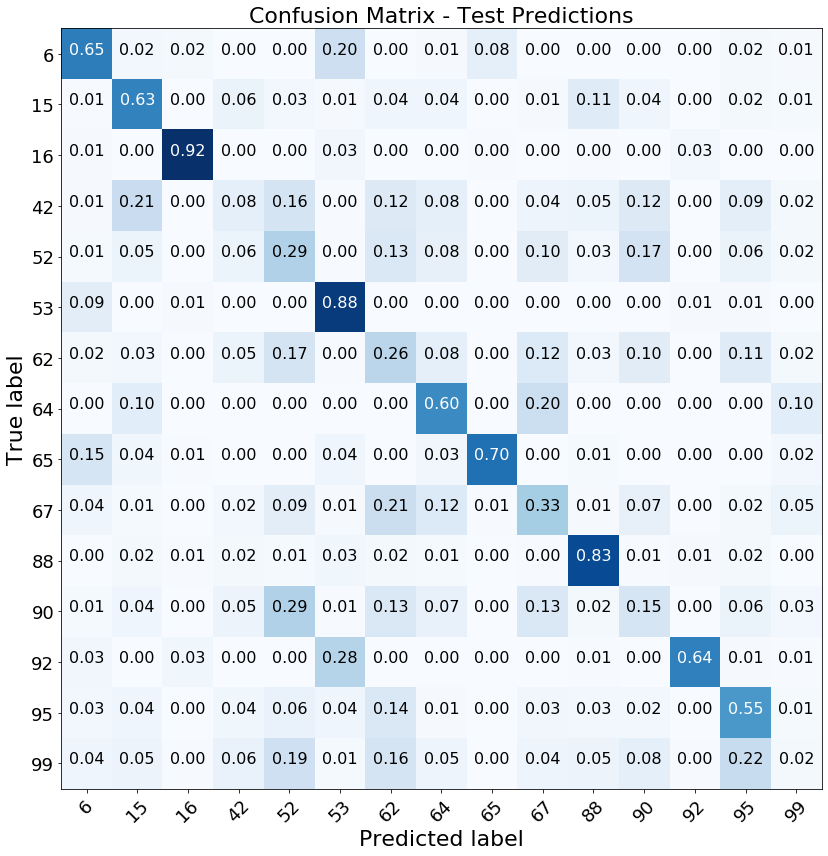

In [10]:
cnf_matrix = confusion_matrix(y_map, np.argmax(np.asarray(testpreds),axis=-1))

cols = np.array(("6","15","16","42","52","53","62","64","65","67","88","90","92","95","99"))

foo = plot_confusion_matrix(cnf_matrix, classes=cols,normalize=True,
                      title='Confusion Matrix - Test Predictions', filename = "confusionmatrix.png")